# How can the company improve collaboration?

## 📖 Background
You work in the analytics department of a multinational company, and the head of HR wants your help mapping out the company's employee network using message data. 

They plan to use the network map to understand interdepartmental dynamics better and explore how the company shares information. The ultimate goal of this project is to think of ways to improve collaboration throughout the company. 

## 💾 The data

The company has six months of information on inter-employee communication. For privacy reasons, only sender, receiver, and message length information are available [(source)](https://snap.stanford.edu/data/CollegeMsg.html). 

#### Messages has information on the sender, receiver, and time.
- "sender" - represents the employee id of the employee sending the message.
- "receiver" - represents the employee id of the employee receiving the message.
- "timestamp" - the date of the message.
- "message_length" - the length in words of the message.

#### Employees has information on each employee;
- "id" - represents the employee id of the employee.
- "department" - is the department within the company. 
- "location" - is the country where the employee lives.
- "age" - is the age of the employee.

_**Acknowledgments:** Pietro Panzarasa, Tore Opsahl, and Kathleen M. Carley. "Patterns and dynamics of users' behavior and interaction: Network analysis of an online community." Journal of the American Society for Information Science and Technology 60.5 (2009): 911-932._

# Executive Summary

This analysis examines where the company is succeeding and falling short in communication and collaboration. A company should always seek to improve in these areas; and as is shown later, approximately 13% of the company makes up 100% of communication, which should be alarming. Recommendations to boost performance will be made based on the results of analysis.

The data explored is message data over the June-November 2021 timeframe, and employee information (id, age, location, department). The analysis is performed both on an individual and a departmental level to identify areas where improvements can be made. The top performing employees in contacts and number of messages sent are identified in the individual analysis, and the departments are ranked based on their message activity in the departmental analysis.

Ultimately, the HR department should determine how to improve communication, the analysis will only show them where their efforts can best be focused.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
import pandas as pd

messages = pd.read_csv('data/messages.csv', parse_dates= ['timestamp'])
messages

,sender,receiver,timestamp,message_length
0,79,48,2021-06-02 05:41:34,88
1,79,63,2021-06-02 05:42:15,72
2,79,58,2021-06-02 05:44:24,86
3,79,70,2021-06-02 05:49:07,26
4,79,109,2021-06-02 19:51:47,73
...,...,...,...,...
3507,469,1629,2021-11-24 05:04:57,75
3508,1487,1543,2021-11-26 00:39:43,25
3509,144,1713,2021-11-28 18:30:47,51
3510,1879,1520,2021-11-29 07:27:52,58


In [3]:
employees = pd.read_csv('data/employees.csv')
employees

,id,department,location,age
0,3,Operations,US,33
1,6,Sales,UK,50
2,8,IT,Brasil,54
3,9,Admin,UK,32
4,12,Operations,Brasil,51
...,...,...,...,...
659,1830,Admin,UK,42
660,1839,Admin,France,28
661,1879,Engineering,US,40
662,1881,Sales,Germany,57


In [4]:
avg_msg_len = messages.message_length.mean()
print(f"The average message length is {np.int(np.floor(avg_msg_len))} words")

The average message length is 48 words


In [5]:
messages_grouped = messages.loc[:, "sender":"receiver"].groupby("sender")
from_to = messages_grouped.value_counts().index
from_to_count = messages_grouped.value_counts().values
merged = employees.merge(messages, left_on="id", right_on="sender", how="left")

In [6]:
merged.receiver.fillna(0, inplace=True)
merged.sender.fillna(0, inplace=True)

In [7]:
new_col = np.zeros(len(merged))

In [8]:
merged["received_msg"] = new_col

In [9]:
messages_dict = {}
for i in range(len(from_to)):
    if from_to[i][0] in messages_dict.keys():
        messages_dict[from_to[i][0]].append([from_to[i][1], from_to_count[i]])
    else:
        messages_dict[from_to[i][0]] = [[from_to[i][1], from_to_count[i]]]

In [10]:
received_dict = {}
for i in messages_dict.keys():
    for j in range(len(messages_dict[i])):
        if messages_dict[i][j][0] in received_dict.keys():
            received_dict[messages_dict[i][j][0]] += 1
        else:
            received_dict[messages_dict[i][j][0]] = 1

In [11]:
for i in employees.id:
    if i not in received_dict.keys():
        received_dict[i] = 0
for i in range(len(merged)):
    merged.received_msg[i] = received_dict[merged.id[i]]

In [12]:
no_sent = merged.query("sender == 0")
no_received = merged.query("received_msg == 0").id.unique()
no_contact = merged.query("(sender == 0) & (received_msg == 0)")
print(f"{no_sent.shape[0]} employees did not send any messages, {664-no_sent.shape[0]} employees did.")
print(f"{no_received.shape[0]} employees did not receive any messages")
print(f"{no_contact.shape[0]} employees had no contact in the workplace")
#Everyone in the company sent or received at least one message

579 employees did not send any messages, 85 employees did.
47 employees did not receive any messages
0 employees had no contact in the workplace


# Preliminary Data Changes/Findings

The provided dataframes were combined into a single dataframe, allowing us to see messages sent by each employee id. A column counting the number of messages each employee had received was added to the merged dataframe. This also allowed interesting preliminary findings, namely:

1. of the 644 employees, only **85 employees were responsible for sending all 3500+ recorded messages**
2. there were 47 employees that did not receive any messages
3. every employee sent or received at least one message.

Combining points 2 and 3 above, we infer that these **47 employees sent messages but received no response**. This may be a talking point for HR, as communication must flow both ways to be effective, especially when the number of employees sending messages is so relatively low. We will look at each of the employees individually next.

In [13]:
Adj = np.zeros([664,664])
for i in range(664):
    for j in range(664):
        if employees.id[i] in messages_dict.keys():
            for k in range(len(messages_dict[employees.id[i]])):
                if employees.id[j] == messages_dict[employees.id[i]][k][0]:
                    Adj[i][j] = messages_dict[employees.id[i]][k][1]

In [14]:
connections = []
for i in range(664):
    connections.append((Adj[i] > 0).sum())
max_connections_loc = np.where(connections == max(connections))[0][0]
max_connections = connections[max_connections_loc]
connected_employee = employees.id.iloc[max_connections_loc]
print(f"employee id {connected_employee} had the most connections with {max_connections}")

employee id 598 had the most connections with 77


In [15]:
%matplotlib inline

In [16]:
consrt = np.sort(connections)
prep_consrt = consrt[np.where(consrt != 0)]

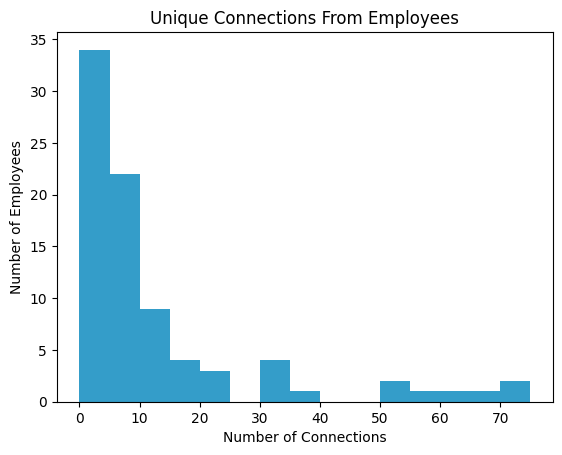

<Figure size 640x480 with 0 Axes>

In [29]:
plt.hist(prep_consrt, color = "#349dc9", bins=np.arange(0,80,5))
plt.xlabel("Number of Connections")
plt.ylabel("Number of Employees")
plt.title("Unique Connections From Employees")
plt.show()
#plt.savefig("employee_connections.png", bbox_inches="tight")
plt.clf()

In [18]:
#We can identify the top 5 most connected employees
connections = np.array(connections)
high_connected_loc = np.where(connections >= 60)
for i in high_connected_loc[0]:
    eid = employees.id.iloc[i]
    val = connections[i]
    print(f"employee id {eid} ({employees.department.iloc[i]}) had {val} connections")

employee id 128 (Sales) had 71 connections
employee id 144 (Sales) had 75 connections
employee id 586 (Operations) had 64 connections
employee id 598 (Operations) had 77 connections
employee id 605 (Admin) had 68 connections


In [19]:
#Also look for activity by number of sent messages
number_sent=[]
for i in range(664):
    ttl = np.sum(Adj[i])
    number_sent.append(ttl)
max_sent_loc = np.where(number_sent == max(number_sent))[0][0]
max_sent = number_sent[max_sent_loc]
talkative_employee = employees.id.iloc[max_sent_loc]
print(f"employee id {talkative_employee} ({employees.department.iloc[max_sent_loc]}) had the most sent messages with {max_sent}")

employee id 605 (Admin) had the most sent messages with 459.0


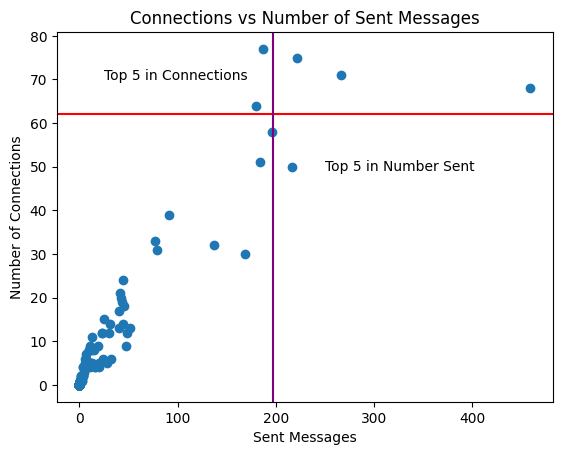

<Figure size 640x480 with 0 Axes>

In [30]:
plt.scatter(x=number_sent, y=connections)
plt.title("Connections vs Number of Sent Messages")
plt.xlabel("Sent Messages")
plt.ylabel("Number of Connections")
plt.axhline(62,color="r")
plt.axvline(197, color="purple")
plt.annotate("Top 5 in Connections", xy=(25,70))
plt.annotate("Top 5 in Number Sent", xy=(250,49))
plt.show()
#plt.savefig("connections_by_sent_msg.png", bbox_inches="tight")
plt.clf()

In [21]:
number_sent = np.array(number_sent)
high_send_loc = np.where(number_sent >= 195)
for i in high_send_loc[0]:
    eid = employees.id.iloc[i]
    val = number_sent[i]
    print(f"employee id {eid} ({employees.department.iloc[i]}) sent {val} messages")

employee id 128 (Sales) sent 266.0 messages
employee id 144 (Sales) sent 221.0 messages
employee id 389 (Sales) sent 196.0 messages
employee id 509 (Admin) sent 216.0 messages
employee id 605 (Admin) sent 459.0 messages


In [22]:
max_contact = merged.received_msg.unique().max()
#print(max_contact)
most_contacted = merged.query("received_msg == 13")
display("The most contacted employee: ", most_contacted)

'The most contacted employee: '

,id,department,location,age,sender,receiver,timestamp,message_length,received_msg
602,194,Admin,US,28,0.0,0.0,NaT,NaN,13.0


In [23]:
eids_dict = {}
dept_dict = {}
dept_dict_reverse = {}
for i in range(664):
    eids_dict[i] = employees.id.iloc[i]
    dept_dict_reverse[employees.id.iloc[i]] = employees.department.iloc[i]
    if employees.department.iloc[i] in dept_dict.keys():
        dept_dict[employees.department.iloc[i]].append(eids_dict[i])
    else:
        dept_dict[employees.department.iloc[i]] = [eids_dict[i]]

In [24]:
cluster0 = []
cluster1 = []
for i in range(664):
    if (Adj[i]==np.zeros(664)).all():
        cluster0.append(i)
    else:
        cluster1.append(i)

In [27]:
sns.scatterplot(x=employees.age, y=number_sent, hue=employees.location)
plt.title("Number of Messages Sent vs Age")
plt.xlabel("Age")
plt.ylabel("Number of Sent Messages")
plt.legend(bbox_to_anchor=(1.25,.825), loc="right", title="Country")
#plt.show()
plt.savefig("msg_sent_by_age.png", bbox_inches="tight")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [28]:
G = nx.DiGraph(Adj)
pos = nx.shell_layout(G, nlist=[cluster0,cluster1])
nx.draw_networkx(G, pos=pos, alpha=0.3, labels=eids_dict)
plt.title("Graph of Connections Between Employees")
plt.xlabel("Outer Circle: Employees that Sent Messages \n\
Inner Circle: Employees that Only Received")
#plt.show()
plt.savefig("ugly_digraph.png", bbox_inches="tight")
plt.clf()

<Figure size 640x480 with 0 Axes>

# Individual Employee Stats

The eye-sore of a graph, ***Graph of Connections Between Employees***, that appears immediately before this is a connection graph. Each blue node represents an employee, with the inner circle being the employees that did not send any messages, and the outer being those that did. The black lines represent a message sent from one node (employee) to another. The fact that it is messy is good, it shows that employees are, in fact, communicating amongst theirselves, or at least reaching out to other employees. To be clear, though, if each employee in the center had sent at least one message, we would have one solid circle and an unreadable mass of lines, almost resembling the scribbling of a pen, in the center. In this graph, more chaos would be a good thing.

Further analysis was done on both the unique number of connections (the number of unique employees one had sent messages to) as well as activity (total number of messages sent) on an individual level. The findings are represented in the figures ***Unique Connections from Employees*** and ***Connections vs Number of Sent Messages***. The former shows that a majority of employees had between 0 and 15 unique connections, while the upper end had upwards of 60. Looking further into this, we see that **employees 598, 144, 128, 605, and 586 had the most unique connections** with: 77, 75, 71, 68, 64, respectively. From the latter figure, we are able to see if this corresponds to the employees who had sent the most messages. We found that **employees 605, 128, 144, 509, and 389 sent the most messages** at 459, 266, 221, 216, and 196, respectively. We are also able to see a clear positive correlation between the number of sent messages and the number of contacts (no employees are sending 400+ texts to only one other employee).

If we seperate the employees by age and location, we do not see much of a difference in the messaging rates between the age groups or countries. In the figure ***Number of Messages Sent vs Age***, there are about 10 nodes clearly above average, mostly in the 30-40 range and from France or USA. However, remembering that there are 85 total senders and over 600 possible senders, age and location do not seem to provide enough new information to justify using these as a metric. We have not examined communication between countries or age groups, but a look at departmental communications should suffice for the purposes of this analysis.

A final note in this section is that we were able to examine the most contacted employee: 194. This employee is in the Admin department and more surprisingly sent no messages. This brings me back to the first talking point in the preliminary section: focusing on making sure that employees respond to received messages (if a response is reasonable), would greatly improve communication at an individual level.

In [31]:
#Looking at departments
sent_by_dept_ind = merged.groupby("department").sender.value_counts()
mid = sent_by_dept_ind.reset_index(level=1, drop=True).reset_index()
sent_by_dept = mid.groupby("department").sum()
sent_by_dept.columns = ["number_sent"]
display(sent_by_dept)

,number_sent
department,
Admin,975
Engineering,118
IT,119
Marketing,65
Operations,1128
Sales,1686


In [32]:
merged["received_dept"] = merged.receiver

In [33]:
for i in employees.id:
    merged.received_dept.replace(i, dept_dict_reverse[i], inplace=True)

In [34]:
from_to_dept = merged.groupby("department").received_dept.value_counts()
#print(from_to_dept)
dept_node_labels = {0:"Ad", 1:"Eng", 2:"IT", 3:"Mk", 4:"Op", 5:"S"}
dept_Adj = np.array([[172,33,48,19,287,298],
                    [4,6,3,0,8,5],
                    [8,6,6,3,10,16],
                    [4,2,0,0,2,8],
                    [245,91,76,40,198,363],
                    [364,114,116,78,340,539]])
colors = ["#349dc9", "#34c963", "#cad43d", "#f74545", "#ed53d9", "#464feb"]
edge_colors = [172,33,48,19,287,298,4,6,3,8,5,8,6,6,3,10,16,4,2,2,8,245,91,76,40,198,363,364,114,116,78,340,539]


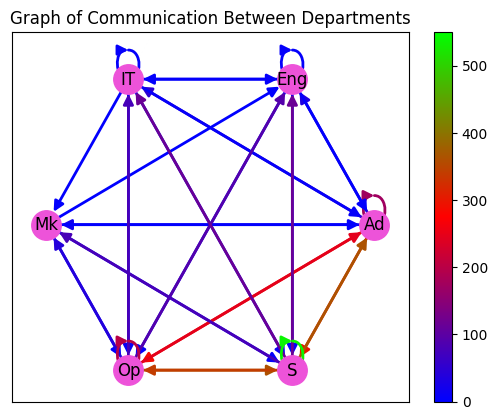

<Figure size 640x480 with 0 Axes>

In [36]:
G1 = nx.DiGraph(dept_Adj)
pos = nx.circular_layout(G1)
nx.draw_networkx(G1, pos=pos, alpha=1, arrowsize=15, labels=dept_node_labels, node_color="#ed53d9", edge_color=edge_colors, edge_cmap=plt.cm.brg, edge_vmin=0, edge_vmax=550, width=2, node_size=450)
plt.title("Graph of Communication Between Departments")
sm = plt.cm.ScalarMappable(cmap=plt.cm.brg, norm=plt.Normalize(0,550))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()
#plt.savefig("dept_digraph.png", bbox_inches="tight")
plt.clf()

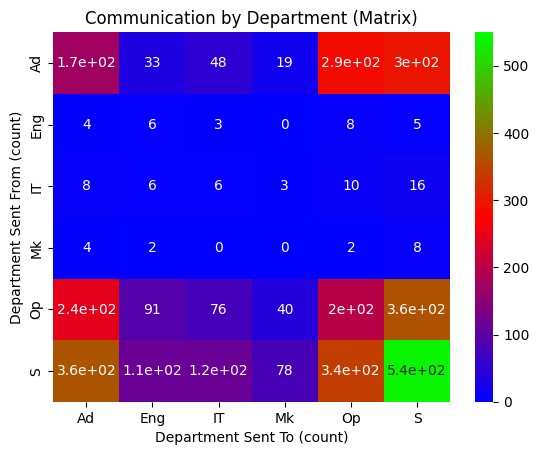

<Figure size 640x480 with 0 Axes>

In [38]:
sns.heatmap(dept_Adj, xticklabels=["Ad","Eng","IT","Mk","Op","S"], yticklabels=["Ad","Eng","IT","Mk","Op","S"], cmap=plt.cm.brg, vmin=0, vmax=550, annot=True, cbar=True)
plt.title("Communication by Department (Matrix)")
plt.ylabel("Department Sent From (count)")
plt.xlabel("Department Sent To (count)")
plt.show()
#plt.savefig("comm_heatmat.png", bbox_inches="tight")
plt.clf()

# Departmental Communication

Now that we are looking at only six data points instead of 664, the connection graph will be much clearer. All of the employees and the messages they sent were aggregated in the dataframe, and after adding a column recording the department that the recipient of each message was in, we are able to track both inter- and intra-departmental communication. Looking at the figure ***Graph of Communication Between Departments***, we see that the arrows indicate most departments are in communication with each other (strength measured by number of messages to/from represented by the color of the line). However, we note that there are two arrows that are not double sided (indicating one way communication), and one missing "loop". Those lacking communication are:

1. Marketing to IT
2. Engineering to Marketing
3. Marketing to Marketing

This is made more clear in the figure ***Communication by Department (Matrix)*** where the cells with a 0 entry indicate no communication. The figure also shows more clearly which departments are the most active and which are least. In order of activity: **Sales, Operations, and Admin are very active**, while **IT, Engineering, and Marketing are clearly inactive**. Here we see a big problem: Marketing should be in close contact with the other departments (and theirselves!) to improve the odds of the Sales department actually making the sale. Additionally, IT and Engineering should at least be in better contact with Admins and each other.

# Conclusion

We have looked at individual and departmental performances throughout this report. From the findings, **employees 128, 605, and 144 can be viewed as the most influential** (in communication), as they are in the top five for total sent messages and number of unique contacts. Further, Sales sends more messages to each other department (and itself) than any other department, so we can say **Sales is the most influential department**. These employees and departments should be commended on their efforts.

In order to boost collaboration company-wide, the HR department should focus on IT, Engineering, and Marketing. As Marketing is the weakest performing department, and perhaps the most traditionally important to sales, **Marketing may be a good department to dedicate more resources to**. Of course, if data can be provided detailing the success of each of the weaker departments' recent prjects, further analysis could be done to better determine which single department it is most important to improve communication with. On an individual note, while it may be impossible to enforce, **HR should encourage inter-personal communication** and appropriate responses to messages. Having only 13% of the employees being responsible for 100% of the communication simply cannot be a good thing.